합성곱 연산, 교차 상관 연산
1. 두 배열
2. 원소수 적은 배열을 미끄러지는 배열, 나머지를 원본 배열로 설정
3. - 합성곱 연산: 미끄러지는 배열의 순서 뒤집기
   - 교차 상관 연산: 변화 무
4. 원본 배열과 미끄러지는 점곱

In [1]:
#합성곱 연산 구현
import numpy as np
w = np.array( [2,1,5,3] )
x = np.array( [2,8,3,7,1,2,0,4,5] )

In [2]:
#1) 원소 수가 적은 배열 순서 뒤집기
w_r = np.flip(w) #넘파이 사용
print(w_r)

w_r = w[::-1] #파이썬 슬라이스 연산자 사용
print(w_r)

[3 5 1 2]
[3 5 1 2]


In [3]:
#넘파이 점곱으로 합성곱 수행
for i in range(6) :
  print(np.dot(x[i:i+4], w_r))

63
48
49
28
21
20


In [4]:
#싸이파이로 합성곱 수행하기
from scipy.signal import convolve
convolve(x, w, mode='valid')

array([63, 48, 49, 28, 21, 20])

In [5]:
#싸이파이로 교차상관 수행하기
from scipy.signal import correlate
correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

    패딩 : 원본배열의 양끝에 빈 원소 추가
    ex)제로 패딩 : 양끝에 '0' 추가
    스트라이드 : 미끄러지는 배열의 간격 조절
    ex)스트라이드 = 2 ->2칸씩 미끄러지며 연산 수행

---



-밸리드 패딩 : 패딩 추가xx, 미끄러지는 배열이 원본 배열 끝으로 갈 때까지 교차상관 수행
  
    (1) 원본 배열의 각 원소의 연산참여도가 서로 다름

    (2) 출력 배열 크기 < 원본 배열 크기

-풀 패딩 : 제로패딩 => 원본 배열 원소의 연산참여도 동일하게 만듦

-세임 패딩 : 출력 배열 길이와 원본 배열 길이 동일하게 제로패딩 추가

In [6]:
print(correlate(x, w, mode='valid')) #벨리드 패딩
print(correlate(x, w, mode='full')) #풀 패딩
print(correlate(x, w, mode='same')) #세임 패딩

[48 57 24 25 16 39]
[ 6 34 51 48 57 24 25 16 39 29 13 10]
[34 51 48 57 24 25 16 39 29]


In [7]:
#2차원 배열에서의 합성곱 수행
x = np.array( [ [1,2,3],
                [4,5,6],
                [7,8,9] ] )
w = np.array( [ [2,0],
                [0,0] ] )
from scipy.signal import correlate2d
correlate2d(x, w, mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [8]:
import tensorflow as tf
x_4d = x.astype(float).reshape(1,3,3,1) #x 4차원으로 변형
w_4d = w.reshape(2,2,1,1) #w 4차원으로 변형

c_out = tf.nn.conv2d(x_4d, w_4d, strides=1, padding='SAME')
#텐서플로 교차상관 / 입력 / 가중치 / 1칸씩 이동 / 세임 패딩(입-출 길이 같)
c_out.numpy().reshape(3,3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

In [9]:
x = np.array( [[1,2,3,4],
              [5,6,7,8],
              [9,10,11,12],
              [13,14,15,16]] )
x = x.reshape(1,4,4,1)
#최대 풀링 (매개변수: 풀링 크기, 스트라이드)
p_out = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='VALID')
p_out.numpy().reshape(2,2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

In [10]:
#렐루 함수 : y=x(x>0) or y=0(x<=0)
def relu(x) :
  return np.maximum(x,0)

x = np.array([-1,-2,0,2,3])
print(relu(x))

r_out = tf.nn.relu(x)
print(r_out.numpy())

[0 0 0 2 3]
[0 0 0 2 3]


In [11]:
#합성곱 신경망 구현하기
class ConvolvtionNetwork :

  def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1) :
    self.n_kernels = n_kernels #합성곱의 커널 개수(몇 개의 특징 조사할 건지)
    self.kernel_size = 3 #커널 크기(필터) 3x3
    self.optimizer = None #옵티마이저(가중치 업데이트 알고리즘을 뭐로 할 거지)
    self.conv_w = None #합성곱층의 가중치(필터)
    self.conv_b = None #합성곱층의 절편
    self.units = units #완전연결층 은닉층의 뉴런 개수
    self.batch_size = batch_size #배치 크기
    self.w1 = None #은닉층의 가중치
    self.b1 = None #은닉층의 절편
    self.w2 = None #출력층의 가중치
    self.b2 = None #출력층의 절편
    self.a1 = None #은닉층의 활성화 출력(역방향계산에 사용)
    self.losses = [] #훈련 손실
    self.val_losses = [] #검증 손실
    self.lr = learning_rate #학습률

  def forpass(self, x) :
    c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b #3x3 합성곱 연산
    r_out = tf.nn.relu(c_out) #렐루 활성화 함수
    p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID') #2x2 최대 폴링
    f_out = tf.reshape(p_out, [x.shape[0], -1]) #첫 번쨰 배치(개수) 차원을 제외하고 출력을 일렬로 펼침
    z1 = tf.matmul(f_out, self.w1) + self.b1 #은닉층 선형식 계산
    a1 = tf.nn.relu(z1) #활성화함수 적용(시그모이드x, 렐루)
    z2 = tf.matmul(a1, self.w2) + self.b2 #출력층 선형식 계산
    return z2

  def init_weights(self, input_shape, n_classes) :
    g = tf.initializers.glorot_uniform()
    self.conv_w = tf.Variable( g((3,3,1, self.n_kernels)) ) #3x3x1x커널개수 가중치 랜덤초기화
    self.conv_b = tf.Variable( np.zeros(self.n_kernels), dtype=float ) #커널개수만큼 절편 초기화
    n_features = 14 * 14 * self.n_kernels #일렬로 펼쳤을 때 개수, 즉 특성개수
    self.w1 = tf.Variable( g((n_features, self.units)) ) #(특성개수, 은닉층 크기)
    self.b1 = tf.Variable( np.zeros(self.units), dtype=float ) #은닉층 크기
    self.w2 = tf.Variable( g((self.units, n_classes)) ) #(은닉층 크기, 클래스 개수)
    self.b2 = tf.Variable( np.zeros(n_classes), dtype=float ) #클래스 개수

  def fit(self, x, y, epochs=100, x_val=None, y_val=None) :
    self.init_weights(x.shape, y.shape[1]) #가중치 초기화
    self.optimizer = tf.optimizers.SGD(learning_rate=self.lr) #가중치 업데이트 알고리즘 - 경사하강법
    for i in range(epochs) :
      print('에포크', i, end='')
      #제너레이터 함수에서 반환한 미니배치 순환
      batch_losses = []
      for x_batch, y_batch in self.gen_batch(x,y) :
        print('.', end='')
        self.training(x_batch, y_batch)
        batch_losses.append(self.get_loss(x_batch, y_batch)) #배치 손실 기록
      print()
      self.losses.append(np.mean(batch_losses)) #배치손실 평균을 내어 훈련손실값으로 저장
      self.val_losses.append(self.get_loss(x_val, y_val)) #검증세트 손실값 저장

  def gen_batch(self, x, y) : #제너레이터 함수 - 배치 나눠줌
    bins = len(x) // self.batch_size #미니 배치 횟수
    indexes = np.random.permutation(np.arange(len(x))) #샘플 인덱스 섞
    x = x[indexes]
    y = y[indexes]
    for i in range(bins) :
      start = self.batch_size * i
      end = self.batch_size * (i+1)
      yield x[start:end], y[start:end] #batch_size만큼 슬라이싱해 반환

  def training(self, x, y) :
    m = len(x) #샘플 개수 저장
    with tf.GradientTape() as tape :
      z = self.forpass(x) #합성곱~풀링~은닉층~출력층 선형 계산까지
      loss = tf.nn.softmax_cross_entropy_with_logits(y,z) #손실 계산
      loss = tf.reduce_mean(loss)
    #가중치 계산
    weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]
    grads = tape.gradient(loss, weights_list) #가중치에 대한 그레이디언트 계산
    self.optimizer.apply_gradients(zip(grads, weights_list)) #가중치 업데이트

  def predict(self, x) :
    z = self.forpass(x) #정방향 계산
    return np.argmax(z.numpy(), axis=1) #가장 큰 값 인덱스 반환

  def score(self, x, y) :
    return np.mean(self.predict(x) == np.argmax(y, axis=1)) #예측==타겟의 열벡터 비교해서 True 비율 반환

  def get_loss(self, x, y) :
    z = self.forpass(x)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y,z))
    return loss.numpy()

In [12]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [14]:
#원-핫 인코딩
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [15]:
x_train = x_train.reshape(-1, 28, 28, 1) #마지막 차원(흑백이라 1) 추가
x_val = x_val.reshape(-1, 28, 28, 1)

In [16]:
#세미 표준화 전처리
x_train = x_train / 255
x_val = x_val / 255

In [17]:
cn = ConvolvtionNetwork(n_kernels=10, units=100, batch_size=2048, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0.......................
에포크 1.......................
에포크 2.......................
에포크 3.......................
에포크 4.......................
에포크 5.......................
에포크 6.......................
에포크 7.......................
에포크 8.......................
에포크 9.......................
에포크 10.......................
에포크 11.......................
에포크 12.......................
에포크 13.......................
에포크 14.......................
에포크 15.......................
에포크 16.......................
에포크 17.......................
에포크 18.......................
에포크 19.......................


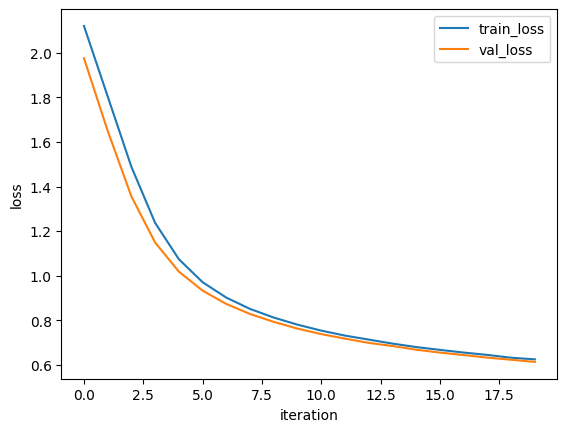

In [18]:
import matplotlib.pyplot as plt

plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend( ['train_loss', 'val_loss'] )
plt.show()

In [19]:
cn.score(x_val, y_val_encoded)

np.float64(0.7915)

# **케라스로 합성곱 신경망 만들기**

In [27]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [29]:
conv1 = tf.keras.Sequential()

conv1.add( Conv2D(10, (3,3), activation='relu', padding='same', input_shape=(28,28,1)) ) #합성곱층 추가
conv1.add( MaxPooling2D(2,2) ) #풀링층 추가 (strides=2, padding='valid' 기본값으로 생략)
conv1.add( Flatten() )#완전연결층에 주입할 수 있게 특성 맵 펼치기
conv1.add( Dense(100, activation='relu') )#완전연결층 - 은닉층 쌓기
conv1.add( Dense(10, activation='softmax') )#완전연결층 - 출력층 쌓기

In [30]:
#모델 구조 살펴보기
conv1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 10)     │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       196,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,210 (770.35 KB)

 Trainable params: 197,210 (770.35 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
history = conv1.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.7827 - loss: 0.6190 - val_accuracy: 0.8825 - val_loss: 0.3325
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - accuracy: 0.8867 - loss: 0.3192 - val_accuracy: 0.8951 - val_loss: 0.3010
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9034 - loss: 0.2651 - val_accuracy: 0.8993 - val_loss: 0.2760
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.9176 - loss: 0.2319 - val_accuracy: 0.9101 - val_loss: 0.2553
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.9250 - loss: 0.2003 - val_accuracy: 0.9083 - val_loss: 0.2614
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9313 - loss: 0.1866 - val_accuracy: 0.9141 - val_loss: 0.2508
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9381 - loss: 0.1656 - val_accuracy: 0.9136 - val_loss: 0.2544
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9468 -

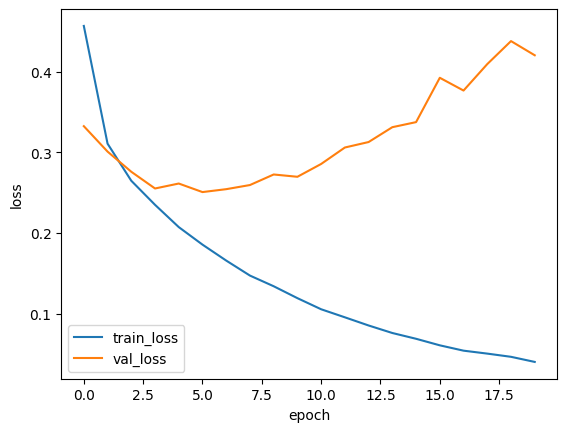

In [33]:
#손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( ['train_loss', 'val_loss'] )
plt.show()

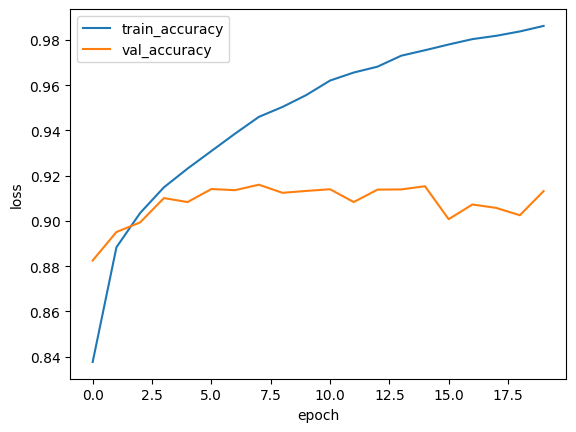

In [34]:
#정확도 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( ['train_accuracy', 'val_accuracy'] )
plt.show()

In [37]:
#드롭아웃 이용하여 과대적합 줄이기
from tensorflow.keras.layers import Dropout

conv2 = tf.keras.Sequential()
conv2.add( Conv2D(10,(3,3),activation='relu', padding='same', input_shape=(28,28,1)) )
conv2.add( MaxPooling2D((2,2)) )
conv2.add( Flatten() )
conv2.add( Dropout(0.5) ) #50%의 드롭아웃
conv2.add( Dense(100, activation='relu') )
conv2.add( Dense(10, activation='softmax') )

In [39]:
conv2.summary()
#드롭아웃층 : 훈련되는 가중치가 없고, 텐서의 차원 바꾸지 않음

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 10)     │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │       196,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,210 (770.35 KB)

 Trainable params: 197,210 (770.35 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
conv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = conv2.fit( x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded) )

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.7605 - loss: 0.6827 - val_accuracy: 0.8773 - val_loss: 0.3481
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.8628 - loss: 0.3826 - val_accuracy: 0.8888 - val_loss: 0.3084
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.8776 - loss: 0.3325 - val_accuracy: 0.8986 - val_loss: 0.2890
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.8841 - loss: 0.3090 - val_accuracy: 0.9064 - val_loss: 0.2660
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 49s 21ms/step - accuracy: 0.8933 - loss: 0.2898 - val_accuracy: 0.9057 - val_loss: 0.2623
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.8999 - loss: 0.2696 - val_accuracy: 0.9070 - val_loss: 0.2561
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.9027 - loss: 0.2570 - val_accuracy: 0.9082 - val_loss: 0.2552
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.9071 -

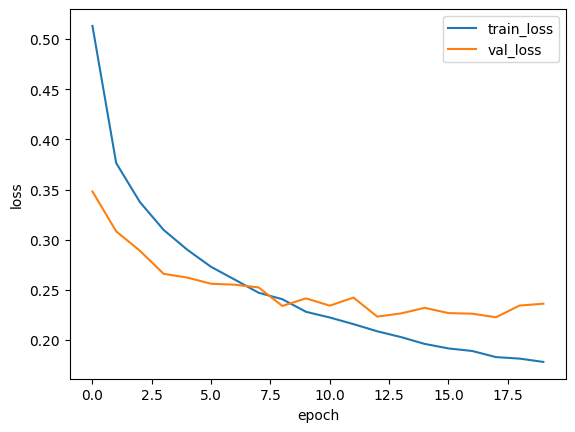

In [41]:
#손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( ['train_loss', 'val_loss'] )
plt.show()

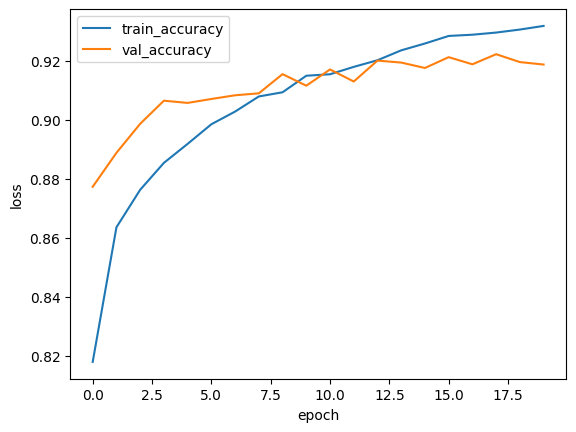

In [42]:
#정확도 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( ['train_accuracy', 'val_accuracy'] )
plt.show()